In [1]:
import praw
import pandas as pd
import spacy
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import networkx as nx
from collections import Counter
import creds
import time


In [2]:
!python -m spacy download en_core_web_sm

     ---------------------------------------- 0.0/12.8 MB ? eta -:--:--
     --------------------------------------  12.6/12.8 MB 87.4 MB/s eta 0:00:01
     --------------------------------------- 12.8/12.8 MB 66.7 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')



[notice] A new release of pip is available: 24.2 -> 25.0.1
[notice] To update, run: C:\Users\gabri\AppData\Local\Microsoft\WindowsApps\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\python.exe -m pip install --upgrade pip


In [3]:
"""Main function to orchestrate the process."""
reddit = praw.Reddit(
    client_id=creds.CLIENT_ID,
    client_secret=creds.CLIENT_SECRET,
    user_agent=creds.USER_AGENTS
)

In [11]:
def fetch_reddit_posts(keywords, subreddits, days=100, limit=2000):
    end_time = datetime.datetime.now(datetime.UTC)
    start_time = end_time - datetime.timedelta(days=days)

    posts = []
    for subreddit in subreddits:
        current_end_time = end_time.timestamp()
        while current_end_time > start_time.timestamp() and len(posts) < limit:
            print(f"Fetching posts before: {datetime.datetime.fromtimestamp(current_end_time, datetime.UTC)}")
            for submission in reddit.subreddit(subreddit).search(
                " OR ".join(keywords),
                sort="new",
                limit=min(100, limit - len(posts)),  # Fetch up to 100 at a time, respecting the overall limit
                params={'before': int(current_end_time)}  # Pass 'before' in the params dictionary
            ):
                if submission.created_utc < start_time.timestamp():
                    break  # Stop if we've gone past the start time

                posts.append({
                    "subreddit": subreddit,
                    "title": submission.title,
                    "text": submission.selftext,
                    "created_utc": submission.created_utc
                })
            if posts:
                current_end_time = posts[-1]['created_utc']
            else:
                break # No more posts found for this time range

    return pd.DataFrame(posts)

keywords = ["lazy", "lousy", "dirty", "bad", "terrible", "horrible", "unreliable"]
subreddits = ["all"]
#subreddits = ["airlines", "Comcast", "healthcare", "railways"]
df = fetch_reddit_posts(keywords, subreddits, days=100)
df["created_date"] = pd.to_datetime(df["created_utc"], unit="s")
print(df.head())
print(df.tail())
print(f"Total posts fetched: {len(df)}")

Fetching posts before: 2025-03-30 17:30:54.264063+00:00
Fetching posts before: 2025-03-30 17:20:26+00:00
Fetching posts before: 2025-03-30 17:20:26+00:00
Fetching posts before: 2025-03-30 17:20:26+00:00
Fetching posts before: 2025-03-30 17:20:26+00:00
Fetching posts before: 2025-03-30 17:20:26+00:00
Fetching posts before: 2025-03-30 17:20:26+00:00
Fetching posts before: 2025-03-30 17:20:26+00:00
Fetching posts before: 2025-03-30 17:20:26+00:00
Fetching posts before: 2025-03-30 17:20:26+00:00
Fetching posts before: 2025-03-30 17:20:26+00:00
Fetching posts before: 2025-03-30 17:20:26+00:00
Fetching posts before: 2025-03-30 17:20:26+00:00
Fetching posts before: 2025-03-30 17:20:26+00:00
Fetching posts before: 2025-03-30 17:20:26+00:00
Fetching posts before: 2025-03-30 17:20:26+00:00
Fetching posts before: 2025-03-30 17:20:26+00:00
Fetching posts before: 2025-03-30 17:20:26+00:00
Fetching posts before: 2025-03-30 17:20:26+00:00
Fetching posts before: 2025-03-30 17:20:26+00:00
  subreddit  

In [12]:
nlp = spacy.load("en_core_web_sm")

def extract_entities(text):
    doc = nlp(text)
    entities = [ent.text for ent in doc.ents if ent.label_ in ["ORG", "GPE", "PRODUCT"]]
    return entities if entities else None

df["entities"] = df["text"].apply(lambda x: extract_entities(x) if isinstance(x, str) else [])
df = df.explode("entities").dropna().reset_index(drop=True)  # Explode list of entities
print(df.head())


  subreddit                                             title  \
0       all        Review #2: Battle of the Wheated - Blind 2   
1       all        Review #2: Battle of the Wheated - Blind 2   
2       all        Review #2: Battle of the Wheated - Blind 2   
3       all        Review #2: Battle of the Wheated - Blind 2   
4       all  My dad went over my private dark notes yesterday   

                                                text   created_utc  \
0  Battle of the Wheateds\n\nThis is the first bl...  1.743356e+09   
1  Battle of the Wheateds\n\nThis is the first bl...  1.743356e+09   
2  Battle of the Wheateds\n\nThis is the first bl...  1.743356e+09   
3  Battle of the Wheateds\n\nThis is the first bl...  1.743356e+09   
4  Im 19. someone robbed my phone yesterday\n\ni ...  1.743356e+09   

         created_date       entities  
0 2025-03-30 17:26:13        Caramel  
1 2025-03-30 17:26:13  the Weller FP  
2 2025-03-30 17:26:13         Weller  
3 2025-03-30 17:26:13        Ant

In [13]:
analyzer = SentimentIntensityAnalyzer()

def get_sentiment(text):
    score = analyzer.polarity_scores(text)
    return score["compound"]

df["sentiment"] = df["text"].apply(lambda x: get_sentiment(x) if isinstance(x, str) else 0)
print(df.head())


  subreddit                                             title  \
0       all        Review #2: Battle of the Wheated - Blind 2   
1       all        Review #2: Battle of the Wheated - Blind 2   
2       all        Review #2: Battle of the Wheated - Blind 2   
3       all        Review #2: Battle of the Wheated - Blind 2   
4       all  My dad went over my private dark notes yesterday   

                                                text   created_utc  \
0  Battle of the Wheateds\n\nThis is the first bl...  1.743356e+09   
1  Battle of the Wheateds\n\nThis is the first bl...  1.743356e+09   
2  Battle of the Wheateds\n\nThis is the first bl...  1.743356e+09   
3  Battle of the Wheateds\n\nThis is the first bl...  1.743356e+09   
4  Im 19. someone robbed my phone yesterday\n\ni ...  1.743356e+09   

         created_date       entities  sentiment  
0 2025-03-30 17:26:13        Caramel     0.9659  
1 2025-03-30 17:26:13  the Weller FP     0.9659  
2 2025-03-30 17:26:13         Weller  

In [26]:
def analyze_top_entities(df):
    """
    Counts the frequency of entities in a DataFrame column and filters the DataFrame
    to include only rows containing the top 5 most frequent entities.

    Args:
        df (pd.DataFrame): DataFrame containing a column named 'entities'
                           (which should be a list of entities per row).

    Returns:
        tuple: A tuple containing:
            - list: A list of the top 5 most frequent entities.
            - pd.DataFrame: A DataFrame filtered to include only rows where
                            the 'entities' column contains one of the top 5 entities.
    """
    # Explode the 'entities' column to count individual entity occurrences
    df_exploded = df.explode("entities").dropna().reset_index(drop=True)

    # Count the frequency of each entity
    top_entities = df_exploded["entities"].value_counts().head(5).index.tolist()

    # Filter dataset to only include these top entities
    df_filtered = df_exploded[df_exploded["entities"].isin(top_entities)].reset_index(drop=True)

    print("Top 5 Entities:", top_entities)
    print(df_filtered.head())

    return top_entities, df_filtered

top_entities_result, df_filtered_result = analyze_top_entities(df.copy())

Top 5 Entities: ['RBC', 'Gabby', 'CBC', 'Man City', 'LOT OF US']
  subreddit                                              title  \
0       all  Post-Match Thread: Bournemouth 1-2 Manchester ...   
1       all  Post-Match Thread: Bournemouth 1-2 Manchester ...   
2       all  Post-Match Thread: Bournemouth 1-2 Manchester ...   
3       all  Post-Match Thread: Bournemouth 1-2 Manchester ...   
4       all  Post-Match Thread: Bournemouth 1-2 Manchester ...   

                                                text   created_utc  \
0  # [](#sprite1-p218)**Bournemouth** [1 - 2](#ba...  1.743356e+09   
1  # [](#sprite1-p218)**Bournemouth** [1 - 2](#ba...  1.743356e+09   
2  # [](#sprite1-p218)**Bournemouth** [1 - 2](#ba...  1.743356e+09   
3  # [](#sprite1-p218)**Bournemouth** [1 - 2](#ba...  1.743356e+09   
4  # [](#sprite1-p218)**Bournemouth** [1 - 2](#ba...  1.743356e+09   

         created_date  entities  sentiment  
0 2025-03-30 17:25:15  Man City     0.9884  
1 2025-03-30 17:25:15  Man 

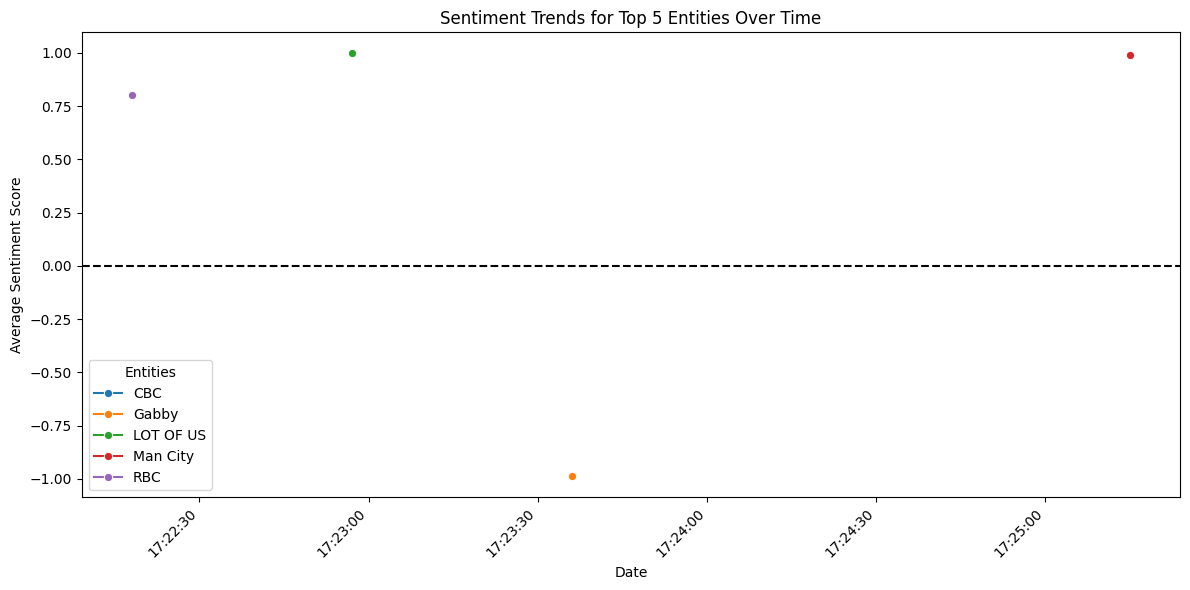

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

def plot_sentiment_trends(df, top_n=5):
    """
    Aggregates sentiment scores by entity and date and plots sentiment trends
    for the top N entities over time.

    Args:
        df (pd.DataFrame): DataFrame containing 'entities', 'created_date', and 'sentiment' columns.
        top_n (int): The number of top entities to plot (default is 5).
    """
    # Explode the 'entities' column if it's still a list
    if isinstance(df['entities'].iloc[0], list):
        df_exploded = df.explode("entities").dropna().reset_index(drop=True)
    else:
        df_exploded = df.copy()

    # Get the top N entities
    top_entities = df_exploded["entities"].value_counts().head(top_n).index.tolist()

    # Filter the DataFrame to include only the top N entities
    df_filtered = df_exploded[df_exploded["entities"].isin(top_entities)].reset_index(drop=True)

    # Aggregate sentiment scores by entity and date
    df_grouped = df_filtered.groupby(["entities", "created_date"]).agg({"sentiment": "mean"}).reset_index()

    # Plot sentiment trends
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=df_grouped, x="created_date", y="sentiment", hue="entities", marker="o")
    plt.axhline(0, color="black", linestyle="--")
    plt.title(f"Sentiment Trends for Top {top_n} Entities Over Time")
    plt.xlabel("Date")
    plt.ylabel("Average Sentiment Score")
    plt.legend(title="Entities")
    plt.xticks(rotation=45, ha='right')  # Rotate and align x-axis labels
    plt.tight_layout()  # Adjust layout to prevent labels from overlapping
    plt.show()

plot_sentiment_trends(df_filtered_result, top_n=5)
